In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

## Initial Data Exploration

In [89]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Train and Test Dataframe Overview:**

* Training dataset is representative of 2/3 of the data (8,693 / 12,970 passengers)
* All columns except for ID and Transported have null values

In [42]:
train.info()
print('-' * 45)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13

In [43]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

**Data Distribution of Numerical Features:**

* Passengers tend to spend the most on health/wellness (food and spa), followed by entertainment (VRDeck).
* Some passengers didn't spend money on anything (4 people spent nothing on food, error?).
* Might be worth considering combining columns into total spending.
* **50% of passengers were transported.**

In [81]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [45]:
train['Transported'].mean()

0.5036236051995858

**Data Distribution of Categorical Features:**

* Over half of the passengers come from Earth.
* Most passengers were not in cryo sleep.
    * Could cryo sleep be an explanation for 0 spending in some categories?
* Most people had their own cabin, but some passengers shared living spaces.
* VIP's are a minority.
* Some people shared the same name.

In [46]:
train.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


## Analyzing Certain Features and Their Correlation with Transportation Rate

* **HomePlanet** - Passengers from Europa had the highest chance of being transported, followed by Mars and Earth.
* **CryoSleep** - Passengers who were in cryo sleep were much more likely to be transported than those who were not.
* **Destination** - Passengers going to 55 Cancri e were slightly more likely to be transported than those headed towards the other two destinations.
* **Cabin (Alone or Not)** - Those sharing cabins with other passengers were slightly more likely to be transported than lone passengers.
* **VIP** - VIP's were slightly less likely to be transported than non-VIP's.

In [23]:
# Home Planet
planet_distr = train[['HomePlanet', 'Transported']].groupby('HomePlanet').mean().sort_values(by='Transported', ascending=False)

planet_counts = train['HomePlanet'].value_counts()
planet_distr['# Passengers'] = planet_counts

planet_distr['# Transported per Planet'] = planet_distr['Transported'] * planet_distr['# Passengers']

planet_distr.rename({'Transported': '% Transported'}, axis=1)

,% Transported,# Passengers,# Transported per Planet
HomePlanet,,,
Europa,0.658846,2131,1404.0
Mars,0.523024,1759,920.0
Earth,0.423946,4602,1951.0


In [54]:
# Cryo Sleep
cryo_distr = train[['CryoSleep', 'Transported']].groupby('CryoSleep').mean().sort_values(by='Transported', ascending=False)

cryo_counts = train['CryoSleep'].value_counts()
cryo_distr['# Cryo/Not'] = cryo_counts

cryo_distr['# Cryo/Not Transported'] = cryo_distr['Transported'] * cryo_distr['# Cryo/Not']

cryo_distr.rename({'Transported': '% Transported'}, axis=1)

,% Transported,# Cryo/Not,# Cryo/Not Transported
CryoSleep,,,
True,0.817583,3037,2483.0
False,0.328921,5439,1789.0


In [55]:
# Destination
dest_distr = train[['Destination', 'Transported']].groupby('Destination').mean().sort_values(by='Transported', ascending=False)

dest_counts = train['Destination'].value_counts()
dest_distr['# Passengers per Destination'] = dest_counts

dest_distr['# Transported per Dest'] = dest_distr['Transported'] * dest_distr['# Passengers per Destination']

dest_distr.rename({'Transported': '% Transported'}, axis=1)

,% Transported,# Passengers per Destination,# Transported per Dest
Destination,,,
55 Cancri e,0.610000,1800,1098.0
PSO J318.5-22,0.503769,796,401.0
TRAPPIST-1e,0.471175,5915,2787.0


In [4]:
# Cabin (alone or not?)
train['Alone'] = np.where(train['Cabin'].duplicated(keep=False), False, True)
test['Alone'] = np.where(test['Cabin'].duplicated(keep=False), False, True)

alone_distr = train[['Alone', 'Transported']].groupby('Alone').mean().sort_values(by='Transported', ascending=False)

alone_counts = train['Alone'].value_counts()
alone_distr['# Alone/Not'] = alone_counts

alone_distr['# Alone/Not Transported'] = alone_distr['Transported'] * alone_distr['# Alone/Not']

alone_distr.rename({'Transported': '% Transported'}, axis=1)

,% Transported,# Alone/Not,# Alone/Not Transported
Alone,,,
False,0.600122,3266,1960.0
True,0.445550,5427,2418.0


In [57]:
# VIP
vip_distr = train[['VIP', 'Transported']].groupby('VIP').mean().sort_values(by='Transported', ascending=False)

vip_count = train['VIP'].value_counts()
vip_distr['# VIP'] = vip_count

vip_distr['# VIP/Not Transported'] = vip_distr['# VIP'] * vip_distr['Transported']

vip_distr

,Transported,# VIP,# VIP/Not Transported
VIP,,,
False,0.506332,8291,4198.0
True,0.381910,199,76.0


### Analyzing Passenger Spending

In [5]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train['Total Spending'] = train[spending_cols].sum(axis=1)
test['Total Spending'] = test[spending_cols].sum(axis=1)

train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total Spending
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,1440.866329
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,2803.045694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,716.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1441.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


Comparing Total Spending to all other spending columns, I noticed that the difference in their distributions was very interesting. For each spending column, ~50% of people didn't spend anything, but only ~25% of people had overall 0 spending. My first question was "What kind of passgeners are 0 spenders?"

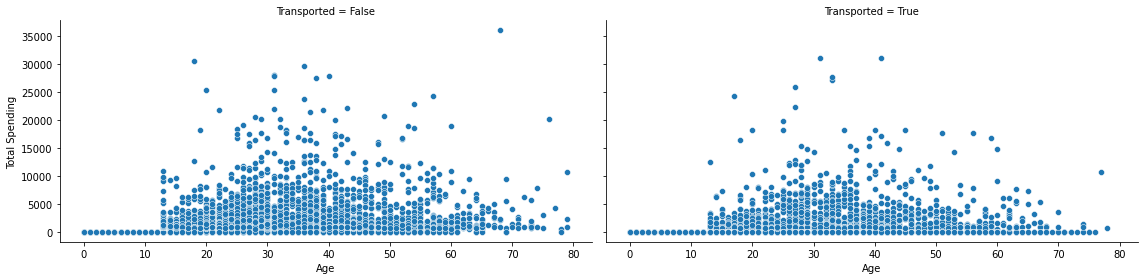

In [59]:
g = sns.FacetGrid(train, col='Transported', height=4, aspect=2)
g.map_dataframe(sns.scatterplot, x='Age', y='Total Spending')

In [60]:
train.loc[train.Age <= 12].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total Spending
count,806.000000,786.0,794.0,786.0,792.0,782.0,806.0
mean,4.516129,0.0,0.0,0.0,0.0,0.0,0.0
std,3.923063,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,8.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,12.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# spending habits of passengers over 12 years old
train.loc[train.Age > 12].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total Spending
count,7708.000000,7548.000000,7541.000000,7524.000000,7540.000000,7548.000000,7708.000000
mean,31.370135,249.450715,507.269991,193.549575,342.860080,336.998013,1594.871562
std,12.727988,700.126901,1689.732240,637.379215,1185.270794,1203.739452,2903.579335
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,787.000000
75%,39.000000,98.000000,150.000000,51.000000,107.250000,84.250000,1669.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,35987.000000


Here, we can see that passengers 12 and under don't spend anything (found through guess and check). It would be useful to remove passengers 12 and under to compare zero-spenders to non-zero spenders.
* **Fun Fact** - 13-year old passengers are the highest spending passengers under 20, also beating 21, 22, 23, and 24-year olds.

In [21]:
over12 = train.loc[train.Age > 12]

In [63]:
over12.loc[over12['Total Spending'] == 0].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Total Spending
count,2758.000000,2701.0,2693.0,2672.0,2701.0,2699.0,2758.0
mean,30.853154,0.0,0.0,0.0,0.0,0.0,0.0
std,12.955205,0.0,0.0,0.0,0.0,0.0,0.0
min,13.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,21.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,28.000000,0.0,0.0,0.0,0.0,0.0,0.0
75%,39.000000,0.0,0.0,0.0,0.0,0.0,0.0
max,78.000000,0.0,0.0,0.0,0.0,0.0,0.0


Even without counting those under 12, there are still 2758 zero-spending passengers. Could there be a correlation between total spending and transportation?

In [52]:
g = sns.FacetGrid(over12, col='Transported', height=4, aspect=2)
g.map(plt.hist, 'Total Spending', bins=50)

NameError: name 'over12' is not defined

In [65]:
zerospend = over12.loc[over12['Total Spending'] == 0]
print('Transportation Rate of Zero-Spenders: ', zerospend['Transported'].mean())

spend = over12.loc[over12['Total Spending'] > 0]
print('Transportation Rate of Spenders: ', spend['Transported'].mean())

# create new feature zero-spending? or leave as is

Transportation Rate of Zero-Spenders:  0.8125453226976069
Transportation Rate of Spenders:  0.2995959595959596


Transportation rate is **highly** correlated with zero/non-zero spending. Zero-spenders have an average transportation rate of **81.25%**, while spenders have an average transportation rate of **only 29.96%**.

**Q:** A large portion of zero-spending passengers are under 12. What does the transportation rate look like for them?

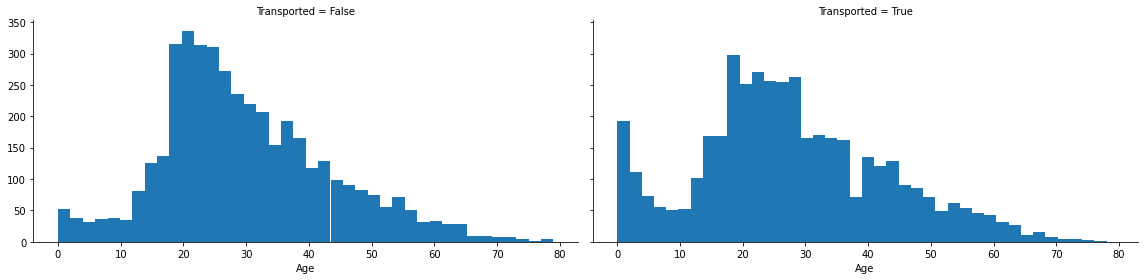

In [66]:
g = sns.FacetGrid(train, col='Transported', height = 4, aspect = 2)
g.map(plt.hist, 'Age', bins=40)

In [67]:
under13 = train.loc[train.Age <= 12]

print('Transportation Rate for Passengers 12 and under: ', under13['Transported'].mean())
print('Transportation Rate for Passengers over 12: ', over12['Transported'].mean())

Transportation Rate for Passengers 12 and under:  0.6997518610421837
Transportation Rate for Passengers over 12:  0.48313440581214323


The transportation rate for passengers under 12 is significantly higher than the average rate (50%). However, the transportation rate of ~70% differs from the average transportation rate 81.25% for zero-spenders, which leads me to believe passengers under 12 are transported at a higher rate because of their age and not because of their zero-spending habits.

In [6]:
train = train.drop(['Name', 'PassengerId', 'Cabin'] + spending_cols, axis=1)
test = test.drop(['Name', 'Cabin'] + spending_cols, axis=1)
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Alone,Total Spending
0,Europa,False,TRAPPIST-1e,39.0,False,False,True,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,True,True,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,False,False,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,False,False,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,True,True,1091.0


## Dealing With NA's

### HomePlanet

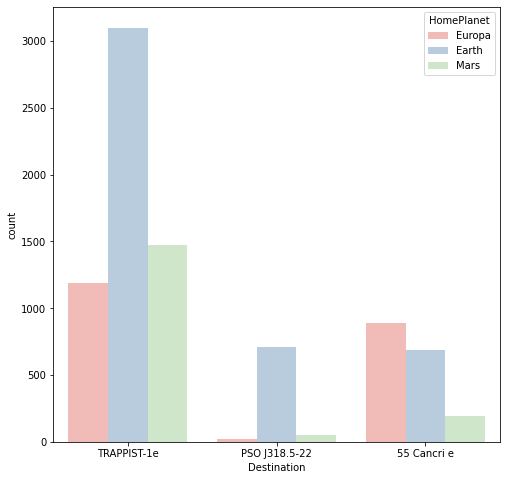

In [27]:
plt.figure(figsize=(8,8))
ax = sns.countplot(data=train, x='Destination', hue='HomePlanet', palette='Pastel1')

Passegners heading towards PSO J318.5-22 are overwhelmingly more likely to be from Earth than the other two planets. TRAPPIST-1e follows the same distribution as the overall distribution of the passengers-planet distribution. While 55 Cancri e has a different distribution, it's not significant enough to replace N/A's using the mode technique, as it would only give a ~50% probability of being accurate.

In [7]:
train['HomePlanet'] = np.where(train.Destination == 'PSO J318.5-22', train.HomePlanet.fillna('Earth'), train.HomePlanet)
test['HomePlanet'] = np.where(test.Destination == 'PSO J318.5-22', test.HomePlanet.fillna('Earth'), test.HomePlanet)

### VIP

In [69]:
vip = train[train.VIP == True]
vip.sort_values(by='Age')

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Alone,Total Spending
3283,Mars,False,TRAPPIST-1e,18.0,True,False,True,1422.0
5845,Mars,False,TRAPPIST-1e,19.0,True,True,True,954.0
4268,Mars,False,PSO J318.5-22,20.0,True,False,True,1850.0
7568,Mars,False,TRAPPIST-1e,23.0,True,False,True,1680.0
8018,Europa,True,TRAPPIST-1e,25.0,True,True,False,0.0
...,...,...,...,...,...,...,...,...
7576,Europa,False,TRAPPIST-1e,69.0,True,False,False,9492.0
779,Europa,False,TRAPPIST-1e,71.0,True,True,True,0.0
2694,Mars,False,TRAPPIST-1e,71.0,True,False,True,2599.0
3104,Europa,True,TRAPPIST-1e,73.0,True,True,True,0.0


Looking only at VIP's, we can guess that a passenger must be at least 18 years old. So for any passenger with a NaN for VIP and an age < 18, we can fill with False.

In [8]:
train['VIP'] = np.where(train.Age < 18, train.VIP.fillna(False), train.VIP)
test['VIP'] = np.where(test.Age < 18, test.VIP.fillna(False), test.VIP)

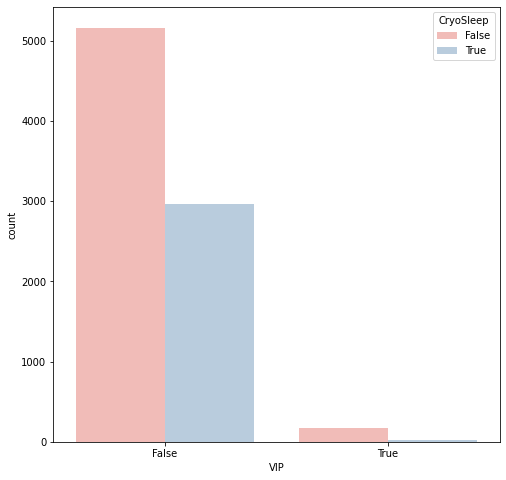

In [34]:
plt.figure(figsize=(8,8))
ax = sns.countplot(data=train, x='VIP', hue='CryoSleep', palette='Pastel1')

For passengers where they are in CryoSleep, most are not VIP's, which might make sense. If you're paying a premium for a VIP experience, you'd probably want to be awake to experience the luxuries that the status provides. 

In [9]:
train['VIP'] = np.where(train.CryoSleep == True, train.VIP.fillna(False), train.VIP)
test['VIP'] = np.where(test.CryoSleep == True, test.VIP.fillna(False), test.VIP)

### CryoSleep

In [11]:
train['CryoSleep'] = np.where(train.VIP == True, train.CryoSleep.fillna(False), train.CryoSleep)
test['CryoSleep'] = np.where(test.VIP == True, test.CryoSleep.fillna(False), test.CryoSleep)

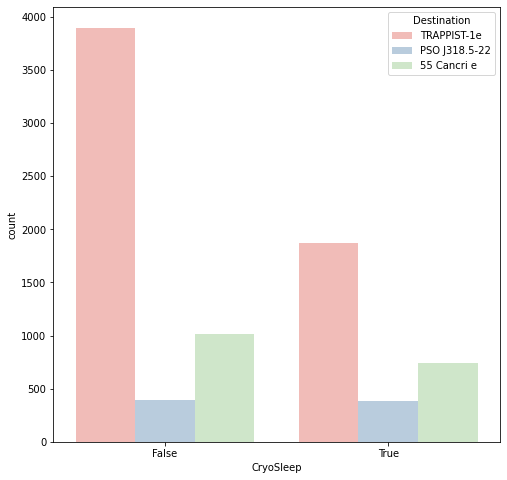

In [10]:
plt.figure(figsize=(8,8))
ax = sns.countplot(data=train, x='CryoSleep', hue='Destination', palette='Pastel1')

### Converting Categorical Variables to Numerical

In [12]:
train_pl_dummy = pd.get_dummies(train['HomePlanet'].dropna()).reindex(train.index)
train_de_dummy = pd.get_dummies(train['Destination'].dropna()).reindex(train.index)
train = pd.concat([train, train_pl_dummy, train_de_dummy], axis=1)

test_pl_dummy = pd.get_dummies(test['HomePlanet'].dropna()).reindex(test.index)
test_de_dummy = pd.get_dummies(test['Destination'].dropna()).reindex(test.index)
test = pd.concat([test, test_pl_dummy, test_de_dummy], axis=1)

In [13]:
train.drop(['HomePlanet', 'Destination'], axis=1, inplace=True)
test.drop(['HomePlanet', 'Destination'], axis=1, inplace=True)

In [40]:
train.head()

,CryoSleep,Age,VIP,Transported,Alone,Total Spending,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,False,39.0,False,False,True,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,False,24.0,False,True,True,736.0,1.0,0.0,0.0,0.0,0.0,1.0
2,False,58.0,True,False,False,10383.0,0.0,1.0,0.0,0.0,0.0,1.0
3,False,33.0,False,False,False,5176.0,0.0,1.0,0.0,0.0,0.0,1.0
4,False,16.0,False,True,True,1091.0,1.0,0.0,0.0,0.0,0.0,1.0


## Imputation

In [14]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights='uniform')

In [15]:
train_imp = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
test_imp = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)

test_imp.drop('PassengerId', axis=1, inplace=True)
test_imp['PassengerId'] = test['PassengerId']

## Classification

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [17]:
X_train = train_imp.drop('Transported', axis=1)
Y_train = train_imp['Transported']
X_test = test_imp.drop('PassengerId', axis=1).copy()

In [18]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = knn.score(X_train, Y_train)
acc_knn

0.8091567928218106

In [19]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = random_forest.score(X_train, Y_train)
acc_random_forest

0.9286782468652939

Between the two models, the Random Forest model provided the best accuracy.

In [27]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Transported": Y_pred
    })

submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission.csv', index=False)